In [1]:
! pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 9.1MB/s 
     |████████████████████████████████| 460kB 31.3MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
from google.colab import files
upload = files.upload()

Saving low_50_company.csv to low_50_company.csv
Saving top_50_company.csv to top_50_company.csv


In [3]:
import pandas as pd
from konlpy.tag import Okt, Kkma
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from numba import jit, cuda
import seaborn as sns
import re
import warnings 

warnings.filterwarnings(action='ignore')

In [4]:
exp_data = pd.read_csv('top_50_company.csv')
con_data = pd.read_csv('low_50_company.csv')
exp_data.head()

,Unnamed: 0,name,total_score,duty,work_state,date,title,pros,cons,wish,like
0,0,페이스북코리아,width:100%;,IT/인터넷,전직원,2020. 07. 31,개발 대우도 잘해주고 여러모로 근무하기 편한 분위기,개방적인 분위기에서 자유롭게 일할 수 있는 환경. 눈치보지 않을 수 있는게 제일 좋음,"핵심 업무 외에 해결해야할 다른 업무들이 조금 있어서, 일에 온전하게 집중하기에는 어렵다",직원들의 요구 사항을 잘 들어주셨으면 좋겠습니다.,0
1,1,페이스북코리아,width:100%;,IT/인터넷,전직원,2020. 07. 17,어떤 직종을 하든 대우가 좋고 보람찬 기업 사내문화는 스마트하며 좋은 문호ㅓ,연차제도가 굉장히 좋고 상사의 눈치가 없음 그리고 무엇보다 수평적인 분위기,보고를 위한 보고서가 많고 거기에 모든 시간을 소비하게 되어 본인의 업무가 많이 늦어짐,신입사원 좀 적극적으로 뽑아주고 능력있는 사원을 구성하여 팀에 보탬이 되게 해주세요,0
2,2,페이스북코리아,width:100%;,마케팅/시장조사,전직원,2020. 04. 24,직원을 어른으로 대우해주는 성숙한 기업이라고 생각합니다. 그만큼 성숙한 사람들이 함...,"재택근무, 연차 사용에 대해서는 원하시는대로 사용하시면 됩니다\r이걸 떠나서, 어른...",업무 강도가 강합니다. 그러나 이걸 단점이라고 보기보다는 얼만큼 욕심내며 일하냐의 ...,제가 있던 직무에서는 없습니다. 너무 좋은 환경이어서 만족을 하며 다녔어요!,6
3,3,페이스북코리아,width:80%;,IT/인터넷,전직원,2020. 03. 16,연봉이 높아서 높아서 사회 초년생일 때 도움이 많이 되었음,연봉이 높다.. 연봉이 높아서 맛있는거 많이 사먹을 수 있다.,정규직이여서 다행이였지만... 비정규직 차별 당하는게 눈에 보여서 안타까웠음...,직원들 잘 챙겨주세요.. 이렇게 가다간 아무도 남지 않을거에요.,7
4,4,페이스북코리아,width:60%;,IT/인터넷,전직원,2020. 03. 03,대우가 좋고 자유로운 분위기인것 같습니다. 친구 따라서 입사하게 되어있는데 너무 좋다,외국계 기업이라 조금 더 수평적인 문화인 것 같고 pto도 더 많이 주는 것 같다,한국에 베이스기 때문에 한국 문화가 섞여 있는 것이 제일 큰 단점.,경영진에게 바라는 것은 더욱 더 수평적이고 transparent한 문화에 힘ㄷ을 써...,1


# Experimetal and Control data compare

Text(0, 0.5, 'Frequency')

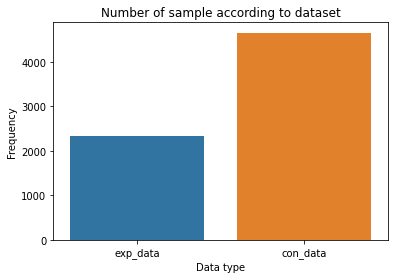

In [5]:
sns.barplot(['exp_data', 'con_data'], [len(exp_data), len(con_data)])
plt.title('Number of sample according to dataset')
plt.xlabel('Data type')
plt.ylabel('Frequency')

Text(0, 0.5, 'frequency')

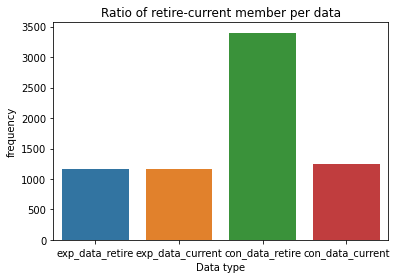

In [6]:
sns.barplot(['exp_data_retire', 'exp_data_current', 'con_data_retire', 'con_data_current'], [(exp_data['work_state']=='전직원').sum(), (exp_data['work_state']=='현직원').sum(), 
                                                                                                  (con_data['work_status']=='전직원').sum(), (con_data['work_status']=='현직원').sum()])
plt.title('Ratio of retire-current member per data')
plt.xlabel('Data type')
plt.ylabel('frequency')

# Total score scoring

* width : 100% -> 5
* width : 80% -> 4 
* width : 60% -> 3
* width : 40% -> 2 
* width : 20% -> 1
* width : 0% -> 0 

In [8]:
def total_score_scoring(data) :
  for idx, sample in enumerate(data.total_score) :
    int_score = re.sub('[^0-9]', '', sample)
    
    if int(int_score) == 100 :
      data['total_score'][idx] = 5

    elif int(int_score) == 80 :
      data['total_score'][idx] = 4

    elif int(int_score) == 60 :
      data['total_score'][idx] = 3

    elif int(int_score) == 40 :
      data['total_score'][idx] = 2

    elif int(int_score) == 20 :
      data['total_score'][idx] = 1

    else :
      data['total_score'][idx] = 0

  return data

In [9]:
exp_data, con_data = total_score_scoring(exp_data), total_score_scoring(con_data)

# Noun Tagging

In [10]:
@jit
def noun_tagging(data, feature_vector) :
  okt = Okt()
  
  for feature in feature_vector :
    data[feature+'_noun'], data[feature+'_adj'] = [0]*len(data), [0]*len(data)

    for idx, corpus in enumerate(data[feature]) :
      noun_corpus = okt.nouns(corpus)

      for noun in noun_corpus :
        if len(noun) <=1 :
          noun_corpus.remove(noun)

      data[feature+'_noun'][idx] = noun_corpus  
    
  return data

In [11]:
exp_data, con_data = noun_tagging(exp_data, ['title', 'pros', 'cons']), noun_tagging(con_data, ['title', 'pros', 'cons'])

In [12]:
exp_data

,Unnamed: 0,name,total_score,duty,work_state,date,title,pros,cons,wish,like,title_noun,title_adj,pros_noun,pros_adj,cons_noun,cons_adj
0,0,페이스북코리아,5,IT/인터넷,전직원,2020. 07. 31,개발 대우도 잘해주고 여러모로 근무하기 편한 분위기,개방적인 분위기에서 자유롭게 일할 수 있는 환경. 눈치보지 않을 수 있는게 제일 좋음,"핵심 업무 외에 해결해야할 다른 업무들이 조금 있어서, 일에 온전하게 집중하기에는 어렵다",직원들의 요구 사항을 잘 들어주셨으면 좋겠습니다.,0,"[개발, 대우, 모로, 근무, 분위기]",0,"[개방, 분위기, 환경, 눈치, 보지, 수, 제일]",0,"[핵심, 업무, 해결, 다른, 업무, 조금, 온전, 집중]",0
1,1,페이스북코리아,5,IT/인터넷,전직원,2020. 07. 17,어떤 직종을 하든 대우가 좋고 보람찬 기업 사내문화는 스마트하며 좋은 문호ㅓ,연차제도가 굉장히 좋고 상사의 눈치가 없음 그리고 무엇보다 수평적인 분위기,보고를 위한 보고서가 많고 거기에 모든 시간을 소비하게 되어 본인의 업무가 많이 늦어짐,신입사원 좀 적극적으로 뽑아주고 능력있는 사원을 구성하여 팀에 보탬이 되게 해주세요,0,"[직종, 하든, 대우, 보람, 기업, 문화, 스마트, 문호]",0,"[연차, 제도, 상사, 눈치, 무엇, 수평, 분위기]",0,"[보고, 보고서, 거기, 모든, 시간, 소비, 본인, 업무]",0
2,2,페이스북코리아,5,마케팅/시장조사,전직원,2020. 04. 24,직원을 어른으로 대우해주는 성숙한 기업이라고 생각합니다. 그만큼 성숙한 사람들이 함...,"재택근무, 연차 사용에 대해서는 원하시는대로 사용하시면 됩니다\r이걸 떠나서, 어른...",업무 강도가 강합니다. 그러나 이걸 단점이라고 보기보다는 얼만큼 욕심내며 일하냐의 ...,제가 있던 직무에서는 없습니다. 너무 좋은 환경이어서 만족을 하며 다녔어요!,6,"[직원, 어른, 대우, 기업, 생각, 사람, 기업인]",0,"[재택근무, 연차, 사용, 대해, 사용, 어른, 대우, 기업, 문화, 최고, 회사,...",0,"[업무, 강도, 단점, 보기, 욕심, 차이]",0
3,3,페이스북코리아,4,IT/인터넷,전직원,2020. 03. 16,연봉이 높아서 높아서 사회 초년생일 때 도움이 많이 되었음,연봉이 높다.. 연봉이 높아서 맛있는거 많이 사먹을 수 있다.,정규직이여서 다행이였지만... 비정규직 차별 당하는게 눈에 보여서 안타까웠음...,직원들 잘 챙겨주세요.. 이렇게 가다간 아무도 남지 않을거에요.,7,"[연봉, 사회, 초년, 생일, 도움]",0,"[연봉, 연봉]",0,"[정규직, 다행, 비정규직, 차별, 보]",0
4,4,페이스북코리아,3,IT/인터넷,전직원,2020. 03. 03,대우가 좋고 자유로운 분위기인것 같습니다. 친구 따라서 입사하게 되어있는데 너무 좋다,외국계 기업이라 조금 더 수평적인 문화인 것 같고 pto도 더 많이 주는 것 같다,한국에 베이스기 때문에 한국 문화가 섞여 있는 것이 제일 큰 단점.,경영진에게 바라는 것은 더욱 더 수평적이고 transparent한 문화에 힘ㄷ을 써...,1,"[대우, 분위기, 친구, 따라서, 입사]",0,"[외국, 기업, 조금, 수평, 문화인, 도, 것]",0,"[한국, 베이스, 때문, 한국, 문화, 제일, 단점]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,57,지란지교소프트,4,IT/인터넷,현직원,2015. 02. 15,회사내 분위기 .좋음 오픈마인드,사무실리모델링으로 인한 환경 개선 및 젊은 기업으로 분위기좋음,특별한단점이 존재하진 않지만 안정적이다는 부분이 만족스럽지않음,여러기회가 되는 기업이되었으면좋겠음.,0,"[회사, 분위기, 오픈, 마인드]",0,"[사무, 실리, 모델링, 환경, 개선, 기업, 분위기]",0,"[단점, 존재, 안정, 부분, 만족]",0
2319,58,지란지교소프트,3,디자인,전직원,2014. 11. 05,복지가 좋지만 연봉이 적음. 근무환경이 좋습니다,다양한 복지와 자유로운 분위기. 회사 마인드가 좋음,사원급의 인사평가가 낮음. 낮은 연봉,업부배분 효율적..,1,"[복지, 연봉, 근무, 환경]",0,"[복지, 분위기, 회사, 마인드]",0,"[사원, 인사, 평가, 연봉]",0
2320,59,지란지교소프트,3,IT/인터넷,전직원,2014. 11. 05,이곳은 점핑을 하기위해 잠시 쉬어가는 회사입니다.,복지는 정말 좋습니다. 포인트제를 활용하여 상품권교환도 해주고 연차와 휴가를 붙여서...,충남대집단이다. 그들끼리 다 해먹는다. 사내 정치가 무슨 대기업수준이다.,오픈마인드 크리에이티브 적으로 다가갔으면 한다.,0,"[점핑, 위해, 잠시, 회사]",0,"[복지, 정말, 포인트, 활용, 상품권, 교환, 연차, 휴가, 사용, 눈치, 주지,...",0,"[충남대, 집단, 끼리, 해먹, 사내, 정치가, 무슨, 대기업, 수준]",0
2321,60,지란지교소프트,3,IT/인터넷,현직원,2014. 06. 12,"야근에 지친 분에겐 권할만 하지만, 연봉을 낮추면서 들어오진 말것. 개발자에게 권하...",대기업들에 비해 자유도가 있음. 완전히 개방된 자유는 아님.\r출산휴가/육아휴직에 ...,연봉이 적다. 매출로 인상률 결정됨. 인상률도 거의 일괄임 (a/b/c 평가제도)....,"IPO , 매출 말고 좀 더 근본적인 고민을 했으면 좋겠음. 미래가 불안함.",0,"[야근, 연봉, 개발자]",0,"[대기업, 자유도, 개방, 자유, 출산휴가, 육아휴직, 대해, 편이, 생각, 뭐, ...",0,"[연봉, 매출, 인상, 결정, 인상, 거의, 일괄, 평가, 제도, 장기, 휴가, 쓰...",0


**wish에 string이 아닌 다른 데이터 타입이 존재하여 에러 발생**  
**우선은 wish를 제외하고 분석 진행** 

# gensim을 이용 LDA 진행

**실험군 기업**

In [14]:
pros = exp_data['pros_noun']
cons = exp_data['cons_noun']

pros_dictionary = corpora.Dictionary(pros)
pros_corpus = [pros_dictionary.doc2bow(text) for text in pros]

cons_dictionary = corpora.Dictionary(cons)
cons_corpus = [cons_dictionary.doc2bow(text) for text in cons]

In [18]:
number_of_topic = 10
number_of_word_in_topic=10

pros_lda_model = LdaModel(pros_corpus, num_topics=number_of_topic, id2word=pros_dictionary, passes=15)
cons_lda_model = LdaModel(cons_corpus, num_topics=number_of_topic, id2word=cons_dictionary, passes=15)

pros_topics = pros_lda_model.print_topics(num_words=number_of_word_in_topic)
cons_topics = cons_lda_model.print_topics(num_words=number_of_word_in_topic)

In [19]:
print("pros topics")
for topic in pros_topics :
  print(topic)

print('---------------------------------------------------------------------------------------------------------------------------------------')

print("cons topics")
for topic in cons_topics :
  print(topic)

pros topics
(0, '0.028*"복지" + 0.027*"회사" + 0.021*"성장" + 0.017*"직원" + 0.013*"대한" + 0.011*"매출" + 0.010*"중소기업" + 0.010*"업계" + 0.009*"최고" + 0.009*"가능성"')
(1, '0.047*"복지" + 0.032*"업무" + 0.019*"제공" + 0.015*"회사" + 0.013*"분위기" + 0.013*"연봉" + 0.013*"개발" + 0.011*"기회" + 0.011*"사업" + 0.010*"부서"')
(2, '0.048*"눈치" + 0.043*"연차" + 0.025*"분위기" + 0.024*"사람" + 0.020*"자유" + 0.020*"휴가" + 0.018*"안보" + 0.018*"사용" + 0.014*"수" + 0.014*"간식"')
(3, '0.028*"회사" + 0.022*"대표" + 0.018*"마인드" + 0.017*"모두" + 0.015*"업무" + 0.014*"모든" + 0.012*"개인" + 0.012*"최고" + 0.011*"체계" + 0.010*"기업"')
(4, '0.056*"문화" + 0.037*"기업" + 0.023*"개인" + 0.021*"복지" + 0.017*"야근" + 0.017*"근무" + 0.016*"수평" + 0.015*"회사" + 0.014*"사람" + 0.013*"관계"')
(5, '0.026*"회사" + 0.023*"생각" + 0.019*"경험" + 0.018*"서비스" + 0.017*"기회" + 0.016*"연봉" + 0.015*"성과" + 0.015*"기업" + 0.014*"사람" + 0.013*"글로벌"')
(6, '0.046*"제공" + 0.033*"점심" + 0.031*"아침" + 0.030*"저녁" + 0.020*"간식" + 0.017*"가능" + 0.016*"직원" + 0.016*"식사" + 0.014*"무료" + 0.014*"칼퇴"')
(7, '0.034*"직원" + 0.030*"회사" + 0.024

## 장점 관련 Topic
* 복지 및 성장가능성
* 업계 내 준수한 연봉 
* 휴가를 눈치 안보고 사용가능
* 체계적이고 친직원적인 대표의 마인드
* 수평적인 기업 문화
* 성과에 따른 수당
* 식사 및 간식 제공
* 자율적으로 일할 수 있는 환경



**대조군 기업**

In [21]:
pros = con_data['pros_noun']
cons = con_data['cons_noun']

pros_dictionary = corpora.Dictionary(pros)
pros_corpus = [pros_dictionary.doc2bow(text) for text in pros]

cons_dictionary = corpora.Dictionary(cons)
cons_corpus = [cons_dictionary.doc2bow(text) for text in cons]

In [22]:
number_of_topic = 10
number_of_word_in_topic=10

pros_lda_model = LdaModel(pros_corpus, num_topics=number_of_topic, id2word=pros_dictionary, passes=15)
cons_lda_model = LdaModel(cons_corpus, num_topics=number_of_topic, id2word=cons_dictionary, passes=15)

pros_topics = pros_lda_model.print_topics(num_words=number_of_word_in_topic)
cons_topics = cons_lda_model.print_topics(num_words=number_of_word_in_topic)

In [23]:
print("pros topics")
for topic in pros_topics :
  print(topic)

print('---------------------------------------------------------------------------------------------------------------------------------------')

print("cons topics")
for topic in cons_topics :
  print(topic)

pros topics
(0, '0.069*"분위기" + 0.039*"야근" + 0.038*"직원" + 0.026*"사람" + 0.018*"회사" + 0.015*"업무" + 0.014*"거의" + 0.013*"수평" + 0.013*"끼리" + 0.013*"지원"')
(1, '0.141*"장점" + 0.035*"회사" + 0.020*"정도" + 0.016*"사람" + 0.015*"생각" + 0.015*"것" + 0.014*"기술" + 0.012*"단점" + 0.010*"나름" + 0.010*"월급"')
(2, '0.031*"월급" + 0.027*"분위기" + 0.026*"업무" + 0.024*"사람" + 0.020*"연령" + 0.018*"직원" + 0.015*"대가" + 0.014*"밀리" + 0.012*"건물" + 0.012*"하나"')
(3, '0.037*"연봉" + 0.034*"복지" + 0.022*"중소기업" + 0.018*"복리" + 0.017*"후생" + 0.016*"혜택" + 0.014*"생각" + 0.014*"대비" + 0.013*"수준" + 0.013*"회사"')
(4, '0.028*"지원" + 0.018*"프로젝트" + 0.017*"급여" + 0.016*"식대" + 0.016*"식비" + 0.015*"야근" + 0.013*"월급" + 0.011*"교통" + 0.011*"글로벌" + 0.011*"밀리"')
(5, '0.086*"회사" + 0.022*"안정" + 0.022*"업계" + 0.015*"초봉" + 0.014*"사람" + 0.011*"월급" + 0.009*"신입" + 0.009*"걱정" + 0.009*"입사" + 0.009*"성장"')
(6, '0.092*"연차" + 0.059*"사용" + 0.044*"눈치" + 0.037*"가능" + 0.034*"자유" + 0.025*"업무" + 0.023*"휴가" + 0.020*"퇴근" + 0.018*"비교" + 0.018*"안보"')
(7, '0.077*"제공" + 0.051*"점심" + 0.039*

## 단점 관련 Topic
* 자기개발의 어려움
* 인사 고과 평가
* 출신에 따른 차별
* 사내정치
* 높은 업무 강도
* 좋지 않은 내부 분위기
* 잦은 야근 및 주말 출근 강요
* 대표 지인의 낙하산
